# Install Libraries

Google Colab doesn't have keras tuner library, so we have to install with this command

In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import cv2
import sys
import glob
import shutil
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import keras_tuner as kt
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [3]:
from PIL import Image
from zipfile import ZipFile
from urllib.error import HTTPError
from urllib.request import urlopen
from keras.utils import img_to_array
from tempfile import NamedTemporaryFile
from urllib.parse import unquote, urlparse
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Using Google Colab

## Downloading Dataset from Kaggle

In [4]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-mask-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F667889%2F1176415%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T150911Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18cbf7063728f4974ccd69335b7443f4c7122d93351e96ab611820b34bb0acc5029aefa5efee1901570cc1f96c30bca3d60519e1ee17ac3b1e559c49ce04e344f2ccbdc14b9841b919d05149fb1b91d32563b784d0f7812b6ae9deb79cff8da0ae4f6783efe21f410d9227fd54f3394db482b271269fe584b140c08568ef30fc20c9b1ac84b62c9a8551460aacdf2ddd2770f0bb4c7ea1fae23e906bf96d4f3a4e322b360ad0e963f820ccfe120c69502119a30aba06b8450a6f10f62f21d209b977f3d261f8da9096ea913236a32b134774ceb5891ae5d8f4061439928e53460893d8f0c572d0b5f05ae979bdd18b7df057c6993480b7e126b335065a02c561'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 416968083 bytes downloaded
Downloaded and uncompressed: face-mask-detection
Data source import complete.


# Directory Structure

There's a different directory structure between Google Colab and Jupyter Notebook.
So, I make two version for dataset paths

## Google Colab

In [5]:
input_data_path = '/kaggle/input/face-mask-detection/images'
annotations_path = "/kaggle/input/face-mask-detection/annotations"
images = [*os.listdir("/kaggle/input/face-mask-detection/images")]
output_data_path =  '.'

## Jupyter Notebook

In [ ]:
input_data_path = 'kaggle/input/face-mask-detection/images'
annotations_path = "kaggle/input/face-mask-detection/annotations"
images = [*os.listdir("kaggle/input/face-mask-detection/images")]
output_data_path =  '/'

# EDA

## Convert annotations data into Pandas Data Frame

To make annotation data more readable, we must convert from XML format to Pandas Data Frame

In [6]:
def parse_annotation_object(annotation_object):
  params = {}
  for param in list(annotation_object):
    if param.tag == 'name':
      params['name'] = param.text
    if param.tag == 'bndbox':
      for coord in list(param):
        if coord.tag == 'xmin':
          params['xmin'] = int(coord.text)
        if coord.tag == 'ymin':
          params['ymin'] = int(coord.text)
        if coord.tag == 'xmax':
          params['xmax'] = int(coord.text)
        if coord.tag == 'ymax':
          params['ymax'] = int(coord.text)

  return params

In [7]:
def merge(dict1, dict2):
  res = {**dict1, **dict2}

  return res

In [8]:
def parse_annotation(path):
  tree = ET.parse(path)
  root = tree.getroot()
  constants = {}
  objects = [child for child in root if child.tag == 'object']
  for element in tree.iter():
    if element.tag == 'filename':
      constants['file'] = element.text[:-4]
    if element.tag == 'size':
      for dim in list(element):
        if dim.tag == 'width':
          constants['width'] = int(dim.text)
        if dim.tag == 'height':
          constants['height'] = int(dim.text)
        if dim.tag == 'depth':
          constants['depth'] = int(dim.text)

  object_params = [parse_annotation_object(obj) for obj in objects]
  full_result = [merge(constants, ob) for ob in object_params]

  return full_result

In [9]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path + '/*.xml')]
full_dataset = sum(dataset, [])
df = pd.DataFrame(full_dataset)

df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss176,400,225,3,with_mask,132,55,157,97
1,maksssksksss176,400,225,3,with_mask,15,68,47,104
2,maksssksksss176,400,225,3,with_mask,55,47,81,80
3,maksssksksss176,400,225,3,with_mask,144,95,169,128
4,maksssksksss176,400,225,3,with_mask,166,66,189,95


Remove image with filename 'maksssksksss0' for testing

In [10]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df['file'] == final_test_image]

images.remove(f'{final_test_image}.png')
df = df.loc[df['file'] != final_test_image]

df

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss176,400,225,3,with_mask,132,55,157,97
1,maksssksksss176,400,225,3,with_mask,15,68,47,104
2,maksssksksss176,400,225,3,with_mask,55,47,81,80
3,maksssksksss176,400,225,3,with_mask,144,95,169,128
4,maksssksksss176,400,225,3,with_mask,166,66,189,95
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss783,400,267,3,with_mask,136,59,153,76
4068,maksssksksss783,400,267,3,with_mask,194,132,210,148
4069,maksssksksss783,400,267,3,with_mask,243,136,258,150
4070,maksssksksss783,400,267,3,with_mask,241,32,261,54


Count every class name

In [11]:
df['name'].value_counts()

name
with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: count, dtype: int64

Plot class Distributions

Text(0, 0.5, 'Name')

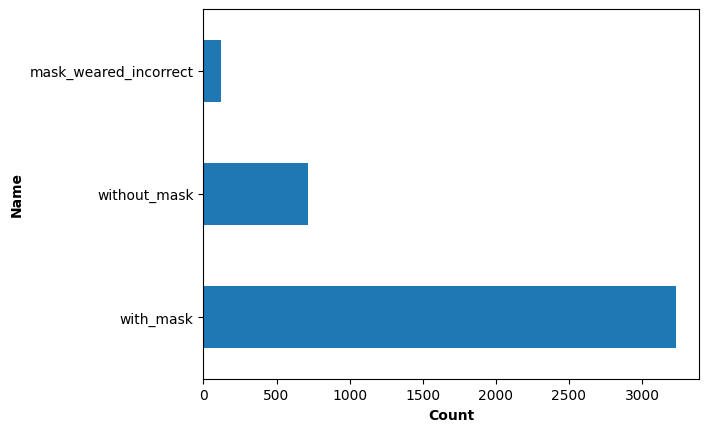

In [12]:
df['name'].value_counts().plot(kind='barh')

plt.xlabel('Count', fontsize=10, fontweight='bold')
plt.ylabel('Name', fontsize=10, fontweight='bold')

Removing 'mask_weared_incorrect' class because we only need two calss with mask or without mask

In [13]:
df = df.drop(df[df['name'] == 'mask_weared_incorrect'].index)

df['name'].value_counts()

name
with_mask       3231
without_mask     715
Name: count, dtype: int64

Text(0, 0.5, 'Name')

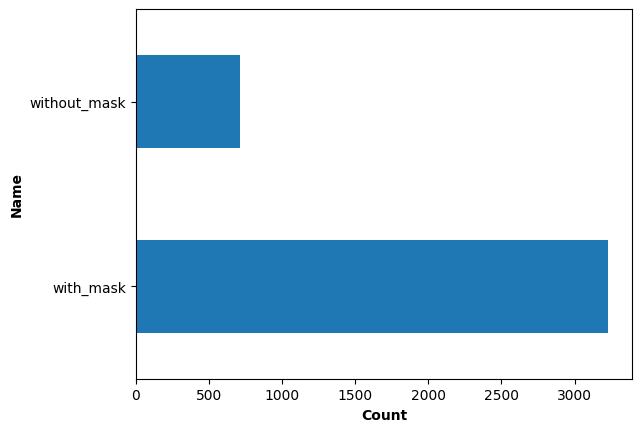

In [14]:
df['name'].value_counts().plot(kind='barh')

plt.xlabel('Count', fontsize=10, fontweight='bold')
plt.ylabel('Name', fontsize=10, fontweight='bold')

## Dataset Splitting

Preparing Splitted Folders

In [15]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']

output_data_path = '.'

for label in labels:
  for d in directory:
    path = os.path.join(output_data_path, d, label)

    if not os.path.exists(path):
      os.makedirs(path)

Crop images based on annotations

In [16]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
  x_shift = (x_max - x_min) * 0.1
  y_shift = (y_max - y_min) * 0.1

  img = Image.open(image_path)
  cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))

  return cropped

In [17]:
def extract_faces(image_name, image_info):
  faces = []
  df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]

  for row_num in range(len(df_one_img)):
    x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num]
    image_path = os.path.join(input_data_path, image_name)

    faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label, f'{image_name[:-4]}_{(x_min, y_min)}'))

  return faces

In [18]:
cropped_images = [extract_faces(img, df) for img in images]

In [19]:
flat_cropped_faces = sum(cropped_images, [])

In [20]:
with_mask = [(img, image_name) for img, label, image_name in flat_cropped_faces if label == 'with_mask']
without_mask = [(img, image_name) for img, label, image_name in flat_cropped_faces if label == 'without_mask']

In [21]:
print(len(with_mask))
print(len(without_mask))

3231
715


Start Splitting

In [22]:
with_mask_train, with_mask_test = train_test_split(with_mask, test_size=0.2, random_state=42)
with_mask_test, with_mask_val = train_test_split(with_mask_test, test_size=0.7, random_state=42)

without_mask_train, without_mask_test = train_test_split(without_mask, test_size=0.2, random_state=42)
without_mask_test, without_mask_val = train_test_split(without_mask_test, test_size=0.7, random_state=42)

Saving Cropped dataset based on Dataset Splitting

In [23]:
def save_image(image, image_name, output_data_path, dataset_type, label):
  output_path = os.path.join(output_data_path, dataset_type, label, f'{image_name}.png')

  image.save(output_path)

In [24]:
for image, image_name in with_mask_train:
  save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in without_mask_train:
  save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in with_mask_test:
  save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in without_mask_test:
  save_image(image, image_name, output_data_path, 'test', 'without_mask')

for image, image_name in with_mask_val:
  save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in without_mask_val:
  save_image(image, image_name, output_data_path, 'val', 'without_mask')

Prepare Data Generator and Transformation

In [25]:
batch_size = 32
target_size = (35, 35)

datagen = ImageDataGenerator(rescale=(1.0 / 255), horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
                                     height_shift_range=0.1, rotation_range=4, vertical_flip=False)
val_datagen = ImageDataGenerator(rescale=(1.0 / 255))

train_generator = datagen.flow_from_directory(directory='train', target_size=target_size, class_mode='categorical',
                                              batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow_from_directory(directory='val', target_size=target_size, class_mode='categorical',
                                              batch_size=batch_size, shuffle=True)
test_generator = val_datagen.flow_from_directory(directory='test', target_size=target_size, class_mode='categorical',
                                              batch_size=batch_size, shuffle=True)

Found 3156 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


# Modeling

For tial and error, we need to make new file instead of overwritting model file to find the best model

In [26]:
def rename_file_if_exists(file_path):
    if not os.path.exists(file_path):
        return file_path

    index = 1
    base_name, ext = os.path.splitext(file_path)
    new_file_path = f'{base_name}_{index}{ext}'

    while os.path.exists(new_file_path):
        index += 1
        new_file_path = f'{base_name}_{index}{ext}'

    return new_file_path

## Build Model and Hyperparameter Tuning



1.   Model Build with 2D Convolutional Neural Network with input shape (35, 35, 3) where '35, 35' target image size and '3' is RGB channel
2.   Hyperparameter Tuned using Hyperband method
3.   Tuned Parameter lists:
      *   Number of Feature Extraction layer (2D Convolution) with maximum 5 layers
      *   Convolution Filter with options: 8, 16, 32 and 64
      *   Kernel Size with option 3x3 or 5x5
      *   Stride with option 1 or 3
      *   Number of Fully Connected layer with maximum 5 layers
      *   Fully connected units with options: 8, 16, 32 and 64
      *   Dropout Rate with range between 0.1 to 0.9 and 0.1 steps
      *   Three option for Optimizer: Adam, RMSProp and SGD
      *   Loss function with option Binary Crossentropy for two output class or Categorical Crossentropy for more than two class
      *   Initiate first learning rate before adapted by callback
4.   Train model configured with 100 epochs, 256 batch size and 3 callbacks:
      *   Model Checkpoint to save best weight only with monitoring validation accuracy
      *   Train will be stopped Early when validation accuracy doesn't improve in 50 epochs
      *   Learning rate will reduced by factor 0.3 when validation accuracy doesn't improve in 10 epocs






In [ ]:
class TrainModel:
    def __init__(self):
        self.epochs = 100
        self.batch_size = 256
        self.es_patience = 50
        self.lr_patience = 10
        self.target_size = (35, 35)

    def build_model(self, hp):
        model = Sequential()

        num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=5, step=1)

        for i in range(num_conv_layers):
            num_conv_filters = hp.Choice(f'num_conv_filters_{i}', values=[8, 16, 32, 64])
            kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
            stride = hp.Choice(f'stride_{i}', values=[1, 3])

            if i == 0:
                model.add(Conv2D(num_conv_filters, kernel_size=kernel_size, strides=stride, padding='same',
                                 activation='relu', input_shape=(35, 35, 3)))
                model.add(MaxPooling2D(padding='same'))
            else:
                model.add(Conv2D(num_conv_filters, kernel_size=kernel_size, strides=stride, padding='same',
                                 activation='relu'))
                model.add(MaxPooling2D(padding='same'))

        model.add(Flatten())

        num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
        for i in range(num_hidden_layers):
            num_units = hp.Choice(f'num_units_{i}', values=[8, 16, 32, 64])
            dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

            model.add(Dense(num_units, activation='relu'))
            model.add(Dropout(dropout_rate))

            if (i == (num_hidden_layers - 1)):
                model.add(Dense(2, activation='sigmoid'))

        optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD'])
        loss_function = hp.Choice('loss_function', values=['binary_crossentropy', 'categorical_crossentropy'])
        learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])
        if optimizer == 'Adam':
            opt = Adam(learning_rate=learning_rate)
            model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

        if optimizer == 'RMSprop':
            opt = RMSprop(learning_rate=learning_rate)
            model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

        if optimizer == 'SGD':
            opt = SGD(learning_rate=learning_rate)
            model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

        return model

    def train_model(self):
        if not os.path.exists('models'):
            os.makedirs('models')

        model_name = 'models/' + str('face_mask_detection_cnn_verihubs_test_AdityaLesmana-new.h5')
        model_name = rename_file_if_exists(model_name)

        cp = ModelCheckpoint(f'{model_name}', monitor='val_accuracy', save_best_only=True,
                             save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)

        early_stopping = EarlyStopping(monitor='val_accuracy', patience=self.es_patience)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=self.lr_patience)

        hyperband_tuner = kt.Hyperband(
            self.build_model,
            objective='val_accuracy',
            max_epochs=self.epochs,
            factor=3,
            seed=42,
            directory='tuners',
            project_name=str('face_mask_detection_cnn_verihubs_test_aditya_lesmana-new')
        )

        best_hyperband_param = {}
        hyperband_tuner.search(train_generator, validation_data=val_generator, epochs=self.epochs, batch_size=self.batch_size,
                               shuffle=True)

        hyperband_results = hyperband_tuner.results_summary()
        best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
        best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)

        best_hyperband_model = best_hyperband_model.fit(train_generator, validation_data=val_generator, epochs=self.epochs,
                                                                  batch_size=self.batch_size, callbacks=[cp, early_stopping, reduce_lr], shuffle=True)

        return best_hyperband_param, hyperband_results, best_hyperband_model

In [ ]:
train_model = TrainModel()
best_hyperband_param, hyperband_results, best_hyperband_model = train_model.train_model()

Trial 254 Complete [00h 03m 10s]
val_accuracy: 0.8414442539215088

Best val_accuracy So Far: 0.9890109896659851
Total elapsed time: 01h 26m 26s
Results summary
Results in tuners\face_mask_detection_cnn_verihubs_test_aditya_lesmana-new
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0146 summary
Hyperparameters:
num_conv_layers: 3
num_conv_filters_0: 16
kernel_size_0: 5
stride_0: 1
num_hidden_layers: 2
num_units_0: 64
dropout_rate_0: 0.5
optimizer: Adam
loss_function: binary_crossentropy
learning_rate: 0.001
num_conv_filters_1: 16
kernel_size_1: 5
stride_1: 1
num_conv_filters_2: 32
kernel_size_2: 5
stride_2: 3
num_conv_filters_3: 8
kernel_size_3: 3
stride_3: 3
num_units_1: 64
dropout_rate_1: 0.7000000000000001
num_units_2: 16
dropout_rate_2: 0.7000000000000001
num_units_3: 32
dropout_rate_3: 0.4
num_units_4: 32
dropout_rate_4: 0.4
num_conv_filters_4: 16
kernel_size_4: 3
stride_4: 3
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tu

# Model Evaluation

## Check model performance

In [29]:
model = load_model('face_mask_detection_cnn_verihubs_test_AdityaLesmana-new.h5')

In [30]:
loss, accuracy = model.evaluate(test_generator)
print(f'Face Mask Detection using CNN and Hyperband tuner has loss: {loss}, accuracy: {accuracy}')

8/8 [==============================] - 2s 22ms/step - loss: 0.0661 - accuracy: 0.9831
Face Mask Detection using CNN and Hyperband tuner has loss: 0.0660507008433342, accuracy: 0.9830508232116699


In [31]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

y_pred

8/8 [==============================] - 0s 12ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

## Plot Training model History

In [ ]:
def plot_model(history):
  history_df = pd.DataFrame(history)
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
  ax[0].set(xlabel='epochs', ylabel='loss')

  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
  ax[1].set(xlabel='epochs', ylabel='accuracy')

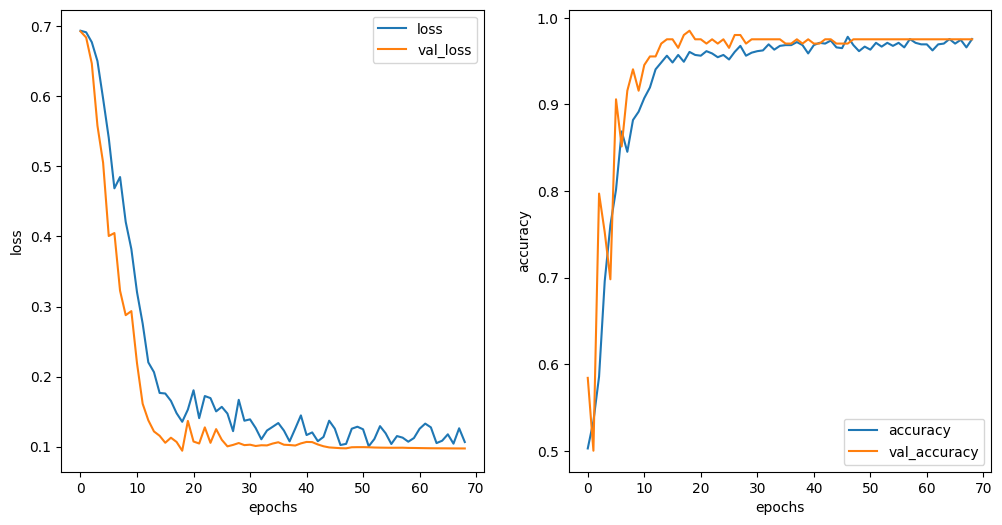

In [ ]:
plot_model(best_hyperband_model.history)

# Testing Model

## Test model using Test Generator

8/8 [==============================] - 0s 16ms/step
True Label is with_mask and Predicting with_mask


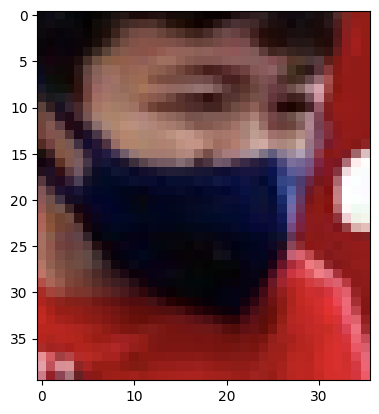

In [32]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

rand_img = np.random.randint(0, len(paths))
img = cv2.imread(os.path.join(output_data_path, 'test', paths[rand_img]))
# Convert color to BGR if using notebook
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

true_label = paths[rand_img].split('/')[0]
pred_label = list(classes)[y_pred[rand_img]]

print(f'True Label is {true_label} and Predicting {pred_label}')
plt.imshow(colored_img)

## Plotting Confusion Matrix using Test Generator

In [33]:
def evaluation(y, y_hat, title='Confusion Matrix'):
  cm = confusion_matrix(y, y_hat)

  sns.heatmap(cm, cmap='PuBu', annot=True, fmt='g', annot_kws={'size': 20})

  plt.xlabel('Predicted', fontsize=10)
  plt.ylabel('Actual', fontsize=10)
  plt.title(title, fontsize=10)

  plt.show()

8/8 [==============================] - 0s 16ms/step


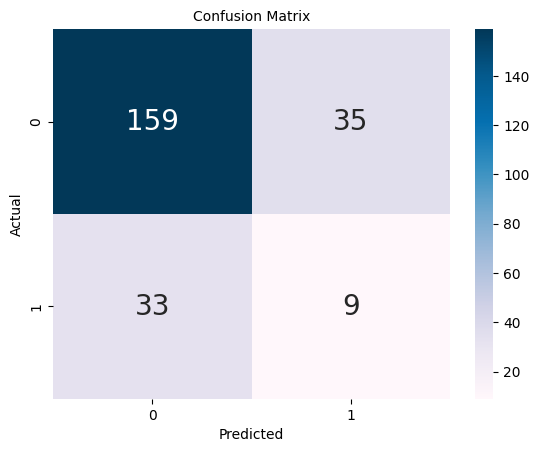

In [34]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1)

evaluation(y_true, y_pred)

# Testing model to Image or Video outside datasets

Create detector function

In [35]:
def detector(frame, model, faces):
    for (x, y, w, h) in faces:
        face_image = frame[y:y + h, x:x + w]

        pred_image = cv2.resize(face_image, (35, 35))
        pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
        pred_image = img_to_array(pred_image) / 255.0
        pred_image = np.expand_dims(pred_image, axis=0)

        prediction = model.predict(pred_image).argmax(axis=1)
        if np.round(prediction[0]) == 0:
            prediction_label = 'Using Mask'
            color = (0, 255, 0)
        else:
            prediction_label = 'Not Using Mask'
            color = (0, 0, 255)

        cv2.rectangle(frame, (x, y), ((x + w), (y + h)), color, 2)
        cv2.putText(frame, f'{prediction_label}', (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    return frame

Initiate Test data

In [36]:
no_mask_path = 'input/[TEST] Not Wearing Mask.jpg'
use_mask_path = 'input/[TEST] Wearing Mask.jpg'
input_vid = 'input/[TEST] Wearing Mask.mp4'
output_vid = 'output/[RESULT] Wearing Mask.mp4'
face_cascade = cv2.CascadeClassifier('input/haarcascade_frontalface_default.xml')

## Test model to Image Data

1/1 [==============================] - 0s 20ms/step


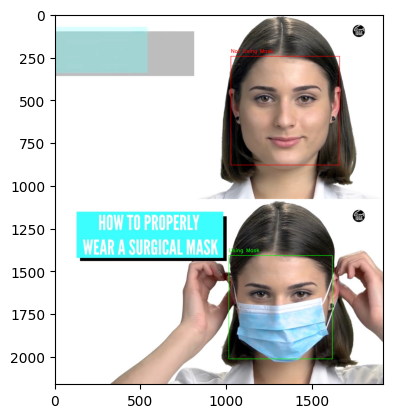

In [37]:
no_mask_image = cv2.imread(no_mask_path)
use_mask_image = cv2.imread(use_mask_path)
stacked_image = cv2.vconcat([no_mask_image, use_mask_image])

faces = face_cascade.detectMultiScale(stacked_image, 1.1, 10)
frame = detector(stacked_image, model, faces)
notebook_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

plt.imshow(notebook_frame)

## Test model to Video Data

This test will be write a new file with detection result because Jupyter Notebook or Google Colab can't show video in real time

In [38]:
cap = cv2.VideoCapture(input_vid)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

fourcc = cv2.VideoWriter_fourcc(* 'mp4v')
video_writter = cv2.VideoWriter(output_vid, fourcc, fps, frame_size)

In [39]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    faces = face_cascade.detectMultiScale(frame, 1.9, 5)
    frame = detector(frame, model, faces)
    video_writter.write(frame)

print('Writing new file completed')
cap.release()
video_writter.release()

1/1 [==============================] - 0s 20ms/step
Writing new file completed
